#### Get text and duration dataframe

In [81]:
from collections import Counter

import torch
import os
import pandas as pd
import numpy as np
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from typing import Union
import seaborn as sns
import pymorphy3
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import matplotlib.pyplot as plt

In [38]:
data_path = '/home/viktor/Projects/Data/MagistracyDeploma/'
test_path = data_path + 'crowd_test/'
raw_crowd_test_path = test_path + 'raw_crowd_test.tsv'
raw_crowd_test = pd.read_csv(raw_crowd_test_path ,sep='\t')
text_column_name = 'speaker_text'
duration_column_name = 'duration'
emotion_column_name = 'annotator_emo'
duration_text = raw_crowd_test[[text_column_name, duration_column_name, emotion_column_name]]
duration_text = duration_text.dropna()
duration_text.head()

,speaker_text,duration,annotator_emo
0,я слушаю,5.82,neutral
1,каким стал сбер,3.70,sad
2,где родился шерлок холмс,4.38,neutral
3,открой в браузере ennio morricone,8.58,neutral
4,каким стал сбер,3.70,sad


In [39]:
duration_text.shape

(77833, 3)

#### Word embeddings

In [40]:
data_folder = '/home/viktor/Projects/Data/MagistracyDeploma/TestHypotheses/'
file_name = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
path = os.path.join(data_folder, file_name)

navec = Navec.load(path)  # ~1 sec, ~100MB RAM

words = ['навек', '<unk>', '<pad>']
ids = [navec.vocab[_] for _ in words]

emb = NavecEmbedding(navec)
vocab = navec.vocab
input = torch.tensor(ids)

emb(input).shape  # 3 x 300


torch.Size([3, 300])

In [41]:
# emb(torch.tensor(navec.vocab['яма']))
def word_to_emb(emb, vocab, word_or_words: Union[str, list[str]]) -> torch.Tensor:
    def single_word_to_emb(emb, vocab, word):
        return emb(torch.tensor(vocab[word]))
    if type(word_or_words) == list:
        result = []
        for word in word_or_words:
            try:
                word_emb = single_word_to_emb(emb, vocab, word)
            except KeyError:
                continue
            result.append(word_emb)
        return result
    else:
        return single_word_to_emb(emb, vocab, word_or_words)

example_word = 'кот'
default_embedding_size = word_to_emb(emb, vocab, example_word).shape.numel()
word_to_emb(emb, vocab, example_word)
# word_to_emb(emb, vocab, ['витя', 'ваня'])

tensor([-0.4161, -0.8234,  0.1041,  0.2171, -0.1972, -0.2072,  0.4124,  0.3353,
         0.4763, -0.1746, -0.3656,  0.6460, -0.2359, -0.4967,  0.2351,  0.0293,
         0.5579, -0.1821,  0.3460, -0.4691, -0.1072, -0.2880, -0.1078,  0.0996,
        -0.4523,  0.4564,  0.6884, -0.1146, -0.0627, -0.2884,  0.3378, -0.2925,
         0.5172,  0.8344, -0.2078, -0.0337, -0.0421,  0.2375,  0.3722,  0.1258,
         0.1039, -0.2675, -0.1411,  0.1203, -0.4903, -0.0273, -0.0957, -0.0155,
         0.3530, -0.0187, -0.2534,  0.0073, -0.1871,  0.2632,  0.0475, -0.4049,
        -0.0334, -0.0777,  0.2896,  0.1553, -0.1509, -0.3095,  0.1722, -0.1822,
        -0.0854, -0.1743,  0.2572,  0.0155,  0.3648,  0.0846,  0.1715, -0.3526,
         0.7443,  0.0164,  0.5548, -0.1972,  0.3350, -0.0060, -0.2826,  0.1762,
        -0.2713,  0.0669, -0.3925,  0.2355,  0.2635,  0.2953, -0.6040,  0.1477,
         0.0168, -0.6317,  0.0766, -0.4718, -0.2756,  0.3199, -0.2244, -0.0384,
         0.2538, -0.1047,  0.2621,  0.05

In [42]:
def bag_of_words(emb, vocab, words: list[str], embedding_size = default_embedding_size) -> torch.Tensor:
    word_embeddings = word_to_emb(emb, vocab, words)
    vector_sum = torch.zeros(embedding_size)
    # if len(word_embeddings) > 0:
    for word in word_embeddings:
        vector_sum += word
    
    return vector_sum / max(len(word_embeddings), 1)

bag_of_words(emb, vocab, ['кот', 'телефон']).shape

torch.Size([300])

In [43]:
text_bags_of_words = []
for text in duration_text['speaker_text']:
    words = text.lower().split(' ')
    text_bags_of_words.append(bag_of_words(emb, vocab, words))

In [44]:
text_bags_of_words_df = pd.DataFrame(text_bags_of_words, dtype='float')
duration_text_bags_of_words_df = pd.concat((duration_text, text_bags_of_words_df), axis=1)


In [45]:
print(duration_text_bags_of_words_df.shape)
duration_text_bags_of_words_df.head()

(77833, 303)


,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,neutral,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,...,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.019849,0.055699
1,каким стал сбер,3.70,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
2,где родился шерлок холмс,4.38,neutral,-0.199201,-0.201970,-0.107651,0.102246,0.001738,-0.182565,-0.134217,...,-0.142165,-0.002077,-0.073691,-0.169712,0.187998,-0.286952,0.018901,-0.215588,-0.194586,-0.000220
3,открой в браузере ennio morricone,8.58,neutral,0.136984,-0.363209,-0.340083,0.231929,-0.179154,0.081780,0.023477,...,-0.294220,0.183978,0.257248,-0.128505,0.063109,-0.345005,0.086596,0.171087,0.158903,-0.257887
4,каким стал сбер,3.70,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355


In [46]:
embedding_feature_names = np.arange(0, default_embedding_size).tolist()
duration_embeddings_names = [duration_column_name] + embedding_feature_names
duration_text_bags_of_words_df[duration_embeddings_names]


,duration,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,5.82,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,0.117051,...,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.019849,0.055699
1,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,-0.271988,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
2,4.38,-0.199201,-0.201970,-0.107651,0.102246,0.001738,-0.182565,-0.134217,-0.035429,0.119740,...,-0.142165,-0.002077,-0.073691,-0.169712,0.187998,-0.286952,0.018901,-0.215588,-0.194586,-0.000220
3,8.58,0.136984,-0.363209,-0.340083,0.231929,-0.179154,0.081780,0.023477,0.386594,0.389532,...,-0.294220,0.183978,0.257248,-0.128505,0.063109,-0.345005,0.086596,0.171087,0.158903,-0.257887
4,3.70,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,0.292174,-0.271988,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77828,4.20,-0.437136,-0.264342,0.056343,0.079929,0.227206,-0.079589,0.259787,0.159116,0.147455,...,-0.057448,-0.425461,-0.008076,0.026868,-0.022649,-0.617909,-0.027230,-0.110793,-0.042576,-0.003898
77829,6.22,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,-0.164615,0.199702,...,0.071241,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588
77830,6.22,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,-0.164615,0.199702,...,0.071241,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588
77831,6.22,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,-0.164615,0.199702,...,0.071241,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588


In [47]:
embeddings_corr = duration_text_bags_of_words_df[duration_embeddings_names].corr()

In [48]:
embedding_threshold = 0.1

(embeddings_corr[duration_column_name].abs() > embedding_threshold).sum()
# embeddings_corr[duration_column_name].abs()

1

In [49]:

punctuation = set(string.punctuation)


def tokens_normalization(transformations, tokens: list[str], delete_punctuation=False) -> list[str]:
    for transformation in transformations:
        tokens = map(transformation, tokens)
    
    if delete_punctuation:
        # tokens = map(lambda x: x.translate(punct_to_none), tokens)
        tokens = filter(lambda x: x not in punctuation, tokens)
        
    return list(tokens)

morph = pymorphy3.MorphAnalyzer()
lemmatizer = lambda x: morph.parse(x)[0].normal_form
transformations = [str.lower, lemmatizer]

tokens_normalization(transformations, ['КоТики'])
tokens_normalization(transformations, [','])

tokenizer_language = 'russian'

tokenizer = lambda x: nltk.word_tokenize(x, language=tokenizer_language)

def text_to_normalized_tokens(text: str, delete_punctuation=False) -> list[str]:
    tokens = tokenizer(text)
    normalized_tokens = tokens_normalization(transformations, tokens, delete_punctuation)
    
    return normalized_tokens

text_to_normalized_tokens('Коты, баОбабы', True)

['кот', 'баобаб']

In [50]:
path = './tf-idf'
token_dict = {}


# def tokenize(text):
#     tokens = nltk.word_tokenize(text)
#     stems = []
#     for item in tokens:
#         stems.append(PorterStemmer().stem(item))
#     return stems

# for dirpath, dirs, files in os.walk(path):
#     for f in files:
#         fname = os.path.join(dirpath, f)
#         print ("fname=", fname)
#         with open(fname) as pearl:
#             text = pearl.read()
#             token_dict[f] = text.lower().translate(None, string.punctuation)

tfidf = TfidfVectorizer(tokenizer=text_to_normalized_tokens, stop_words='english')
tfs = tfidf.fit_transform(['cat dog', 'dog bug'])

s = 'milk milk milk bug bug, dog'
response = tfidf.transform([s])
print(response)

# feature_names = tfidf.get_feature_names()
# for col in response.nonzero()[1]:
#     print (feature_names[col], ' - ', response[0, col])

  (0, 0)	0.9421556246632359
  (0, 2)	0.33517574332792605


/home/viktor/Projects/Univer/Deploma/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [51]:

def texts_to_tfidf_dict(texts):
    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=text_to_normalized_tokens)

    # Fit and transform the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    # Get the feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF values for each word in the text data
    tfidf_values = tfidf_matrix.toarray()

    # Find the most important words based on their TF-IDF values
    most_important_words = {}
    for i, sentence in tqdm(enumerate(texts)):
        for word in text_to_normalized_tokens(sentence, True):
            word_index = np.where(np.array(feature_names) == word)[0]
            if len(word_index) > 0:
                word_index = word_index[0]
                tfidf_score = tfidf_values[i, word_index]
                if word in most_important_words:
                    most_important_words[word] = max(most_important_words[word], tfidf_score)
                else:
                    most_important_words[word] = tfidf_score


    return most_important_words

english_texts = [
    'This is a sample sentence.',
    'Another example a sentence for demonstration purposes.',
    'My name is Viktor',
    'A dog is not cat'
    'Sample sentences help in understanding a TF-IDF vectorization.'
]
russion_texts = [
    'Мама мыла раму.',
    'Мой дядя самых честных правил.',
    'Мой дядя мыл раму дома.',
    'Дома нельзя нарушать правила.'
]

word_to_tfidf = texts_to_tfidf_dict(russion_texts)
word_to_tfidf

4it [00:00, 1067.80it/s]


{'мама': 0.6305035039117027,
 'мыло': 0.4970962045265468,
 'рама': 0.4970962045265468,
 'мой': 0.42882143251767496,
 'дядя': 0.42882143251767496,
 'самый': 0.4916456170427456,
 'честной': 0.4916456170427456,
 'правило': 0.42049336953280086,
 'дом': 0.42882143251767496,
 'нельзя': 0.5333425209202354,
 'нарушать': 0.5333425209202354}

In [52]:
speakers_texts = duration_text_bags_of_words_df['speaker_text'].to_list()
speaker_tfidf_dict = texts_to_tfidf_dict(speakers_texts)

77833it [01:35, 814.60it/s] 


In [53]:
len(speaker_tfidf_dict)

10482

In [82]:
def text_to_mean_tfidf(text, tfidf_dict=speaker_tfidf_dict, tokenizer=text_to_normalized_tokens):
    tokens = tokenizer(text)
    sum_tfidf = 0
    for token in tokens:
        tfidf = tfidf_dict.get(token)
        if tfidf is not None:
            sum_tfidf += tfidf
    return sum_tfidf / max(len(tokens), 1)

text_to_mean_tfidf(russion_texts[0])

0.3541184417614869

In [55]:
all_features = duration_text_bags_of_words_df
all_features.head()

,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,neutral,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,...,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.019849,0.055699
1,каким стал сбер,3.70,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
2,где родился шерлок холмс,4.38,neutral,-0.199201,-0.201970,-0.107651,0.102246,0.001738,-0.182565,-0.134217,...,-0.142165,-0.002077,-0.073691,-0.169712,0.187998,-0.286952,0.018901,-0.215588,-0.194586,-0.000220
3,открой в браузере ennio morricone,8.58,neutral,0.136984,-0.363209,-0.340083,0.231929,-0.179154,0.081780,0.023477,...,-0.294220,0.183978,0.257248,-0.128505,0.063109,-0.345005,0.086596,0.171087,0.158903,-0.257887
4,каким стал сбер,3.70,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355


In [56]:
mean_tfidf_column_name = 'mean_tfidf'
all_features[mean_tfidf_column_name] = all_features['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))

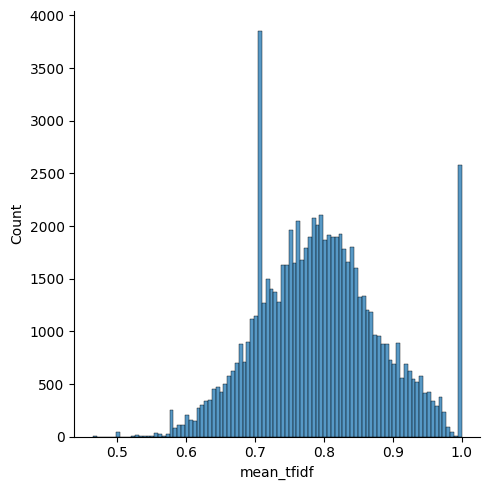

In [57]:
# penguins = sns.load_dataset("penguins")
sns.displot(all_features[mean_tfidf_column_name].to_frame(), x=mean_tfidf_column_name)
# penguins.head()

In [58]:
# all_features.head()['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))
all_features[mean_tfidf_column_name]

0        0.940797
1        0.815491
2        0.721205
3        0.705724
4        0.815491
           ...   
77828    0.654353
77829    0.725484
77830    0.725484
77831    0.725484
77832    0.725484
Name: mean_tfidf, Length: 77833, dtype: float64

First axis - texts, second - words 

In [59]:
all_features[['duration', mean_tfidf_column_name]].corr()

,duration,mean_tfidf
duration,1.000000,-0.153973
mean_tfidf,-0.153973,1.000000


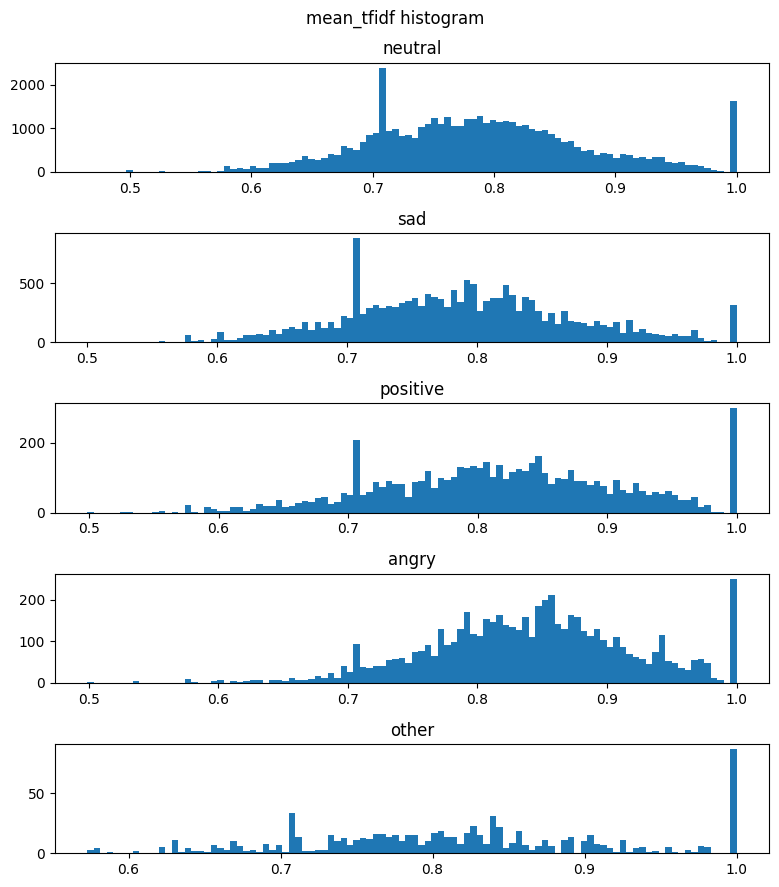

In [60]:
emotions = all_features[emotion_column_name].unique()
bins_number = 100
# plt.hist()
fig, axs = plt.subplots(len(emotions), figsize=(8,9))
fig.suptitle(f'{mean_tfidf_column_name} histogram')
fig.tight_layout()
for i in range(len(emotions)):
    fig.tight_layout()
    axs[i].hist(all_features[all_features[emotion_column_name] == emotions[i]][mean_tfidf_column_name], bins=bins_number)
    axs[i].set_title(emotions[i])
    # axs[i].plot(x, -y)
# plt.hist(all_features[all_features['annotator_emo'] == emotions[1]]['duration'], bins=bins_number)
None

In [61]:
# describe_emotion_by_tfidf = pd.DataFrame()
describe_emotion_by_tfidf= None
for i in range(len(emotions)):
    emotion = emotions[i]
    describe_series = all_features[all_features[emotion_column_name] == emotions[i]][mean_tfidf_column_name].describe()
    if describe_emotion_by_tfidf is None:
        describe_emotion_by_tfidf = describe_series.to_frame()
        # describe_emotion_by_tfidf = describe_emotion_by_tfidf.rename({describe_series.name: emotion})
        describe_emotion_by_tfidf = describe_emotion_by_tfidf.drop(columns=[describe_series.name])
    describe_emotion_by_tfidf[emotion] = describe_series
    
    
describe_emotion_by_tfidf

,neutral,sad,positive,angry,other
count,48578.000000,16690.000000,5775.000000,5987.000000,803.000000
mean,0.787087,0.787701,0.818064,0.840895,0.817951
std,0.089057,0.084357,0.093656,0.079275,0.101059
min,0.464837,0.499990,0.498693,0.498911,0.572848
25%,0.720509,0.726119,0.753776,0.790302,0.750168
50%,0.782334,0.786439,0.817869,0.843588,0.814536
75%,0.840812,0.839698,0.881562,0.891613,0.886127
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
describe_emotion_by_tfidf = all_features[all_features[emotion_column_name] == emotions[i]][mean_tfidf_column_name].describe()
# describe_emotion_by_tfidf.add()

describe_emotion_by_tfidf.to_frame().rename({describe_emotion_by_tfidf.name: '123'})

,mean_tfidf
count,803.000000
mean,0.817951
std,0.101059
min,0.572848
25%,0.750168
50%,0.814536
75%,0.886127
max,1.000000


##### Average coords value for all emotion types

In [63]:
all_features.head()
# for emotion in emotions:
    # all_features[all_features[emotion_column_name] == emotion][[str(i) for i in range(0, 300)]].mean(axis=0)

embedding_feautes = [i for i in range(0, 300)]
embedding_feautes.append(emotion_column_name)
embedding_feautes
all_features[embedding_feautes].groupby(emotion_column_name).mean()
# all_features.columns

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
annotator_emo,,,,,,,,,,,,,,,,,,,,,
angry,-0.048325,-0.159754,-0.099051,-0.003465,-0.126016,-0.210903,0.111279,0.139091,0.022637,-0.141279,...,0.027198,0.158465,-0.019262,0.040426,0.026666,-0.317182,0.084268,-0.097220,-0.123976,0.157442
neutral,0.031516,-0.163326,-0.069133,-0.001985,-0.054704,-0.145235,0.102531,0.072719,0.073665,-0.087258,...,0.057389,0.019774,0.016290,0.035793,0.055911,-0.203372,0.010343,-0.082535,-0.024856,0.132959
other,0.001175,-0.141374,-0.052648,0.003718,-0.083738,-0.162969,0.105705,0.086705,0.010688,-0.127806,...,0.052578,0.075943,-0.007231,0.040757,0.023184,-0.216984,0.031257,-0.122045,-0.066357,0.131827
positive,-0.007904,-0.159592,-0.081678,0.021480,-0.100774,-0.158541,0.121289,0.087906,0.015392,-0.147423,...,0.027748,0.066459,-0.027828,0.069709,0.012820,-0.258133,0.070571,-0.169416,-0.048735,0.158280
sad,0.040792,-0.167781,-0.077883,0.005924,-0.045108,-0.146117,0.104099,0.068894,0.079180,-0.098872,...,0.058638,0.015368,0.024363,0.041003,0.047069,-0.215688,0.013315,-0.085333,-0.034482,0.139860


#### Emotions key words

In [69]:
text_emo_df = all_features[[text_column_name, emotion_column_name]].copy()
text_emo_df.head()

,speaker_text,annotator_emo
0,я слушаю,neutral
1,каким стал сбер,sad
2,где родился шерлок холмс,neutral
3,открой в браузере ennio morricone,neutral
4,каким стал сбер,sad


In [96]:
sample = text_emo_df[text_column_name].head()
    
# emotion_word_counter
emotion_word_counter_dict = {}
for emotion in emotions:
    current_emotion_subdf = text_emo_df[text_emo_df[emotion_column_name] == emotion][text_column_name]
    emotion_word_counter = Counter({})
    
    for text in current_emotion_subdf:
        emotion_word_counter.update(text_to_normalized_tokens(text))
    emotion_word_counter_dict[emotion] = emotion_word_counter
    

0                             я слушаю
2             где родился шерлок холмс
3    открой в браузере ennio morricone
5                             я слушаю
6             где родился шерлок холмс
Name: speaker_text, dtype: object
1                          каким стал сбер
4                          каким стал сбер
8                          каким стал сбер
18    позови мне кого нибудь другого лезть
36                      у меня зуб выпадал
Name: speaker_text, dtype: object
12           а там и ева проснулись с утра
21    позови мне кого нибудь другого лезть
24            джой доброе утро влезал обед
25            джой доброе утро влезал обед
27               передай привет моей семье
Name: speaker_text, dtype: object
19                          браузер открой
20                          браузер открой
22    позови мне кого нибудь другого лезть
23                          браузер открой
32                          иди нахуй стоп
Name: speaker_text, dtype: object
42                      

In [118]:
text_emo_df.shape

(77833, 2)

In [102]:
for emotion, word_counter in emotion_word_counter_dict.items():
    print(emotion, ':', list(word_counter.most_common(10)))

neutral : [('я', 3555), ('ты', 3371), ('в', 2771), ('включить', 2760), ('на', 2746), ('фильм', 2401), ('песня', 2027), ('что', 2021), ('как', 1740), ('не', 1730)]
sad : [('я', 1607), ('включить', 1167), ('на', 982), ('ты', 947), ('не', 883), ('в', 815), ('фильм', 755), ('песня', 670), ('как', 646), ('серия', 615)]
positive : [('я', 1242), ('ты', 1174), ('а', 394), ('у', 313), ('салют', 300), ('с', 292), ('в', 292), ('как', 280), ('на', 277), ('что', 263)]
angry : [('ты', 2448), ('я', 1431), ('не', 1060), ('что', 741), ('а', 354), ('в', 320), ('блядь', 311), ('на', 281), ('это', 273), ('как', 257)]
other : [('ты', 150), ('я', 91), ('что', 68), ('не', 59), ('а', 41), ('в', 37), ('на', 34), ('как', 29), ('песня', 29), ('хотеть', 28)]


Most significant words in each emotion

In [125]:
word_occurancy_in_specific_emotion_ratio = 0.02
most_common_words_number = 10

emotion_most_common_words = {}

for emotion, word_counter in emotion_word_counter_dict.items():
    word_tfidf = []
    for word, occurances_number in emotion_word_counter_dict[emotion].items():
        # count occurances number of this word in all corpus of texts
        if occurances_number/len(emotion_word_counter_dict[emotion]) > word_occurancy_in_specific_emotion_ratio:
            total_occurances_number = 0
            for word_counter in emotion_word_counter_dict.values():
                total_occurances_number += word_counter[word]
            
            word_tfidf.append((word, occurances_number/total_occurances_number))
    
    word_tfidf.sort(key=lambda x: -x[1])
    emotion_most_common_words[emotion] = word_tfidf[:most_common_words_number]

for emotion, words in emotion_most_common_words.items():
    print(emotion, ':', words)


neutral : [('окко', 0.8310344827586207), ('запустить', 0.8305084745762712), ('третий', 0.799410029498525), ('пятый', 0.7837837837837838), ('майнкрафт', 0.7649253731343284), ('тв', 0.7574468085106383), ('клип', 0.7365010799136069), ('супер', 0.735191637630662), ('влад', 0.734982332155477), ('фильм', 0.7342507645259939)]
sad : [('тогда', 0.41832669322709165), ('новость', 0.4162303664921466), ('пять', 0.36192109777015435), ('делать', 0.34063745019920316), ('кино', 0.3377926421404682), ('мультик', 0.32554744525547447), ('мультфильм', 0.3216374269005848), ('машина', 0.31754874651810583), ('второй', 0.30781758957654726), ('большой', 0.2995169082125604)]
positive : [('купаться', 0.7653061224489796), ('молодец', 0.5763888888888888), ('ха', 0.5620915032679739), ('салют', 0.4754358161648177), ('привет', 0.4660633484162896), ('красивый', 0.4553191489361702), ('приятно', 0.45454545454545453), ('спасибо', 0.45318352059925093), ('лайк', 0.4175257731958763), ('тоже', 0.37850467289719625)]
angry : [('

In [106]:
top_words_quantity = 3

for emotion, words in emotion_most_common_words.items():
    for word, _ in words[:top_words_quantity]:
        # get word embedding
        current_word_embedding = word_to_emb(emb, vocab, word)
        
        # count average cosine distance in corpus of text for every emotion

dict_keys(['neutral', 'sad', 'positive', 'angry', 'other'])

In [128]:
numel = word_to_emb(emb, vocab, 'кот')
numel

tensor([-0.4161, -0.8234,  0.1041,  0.2171, -0.1972, -0.2072,  0.4124,  0.3353,
         0.4763, -0.1746, -0.3656,  0.6460, -0.2359, -0.4967,  0.2351,  0.0293,
         0.5579, -0.1821,  0.3460, -0.4691, -0.1072, -0.2880, -0.1078,  0.0996,
        -0.4523,  0.4564,  0.6884, -0.1146, -0.0627, -0.2884,  0.3378, -0.2925,
         0.5172,  0.8344, -0.2078, -0.0337, -0.0421,  0.2375,  0.3722,  0.1258,
         0.1039, -0.2675, -0.1411,  0.1203, -0.4903, -0.0273, -0.0957, -0.0155,
         0.3530, -0.0187, -0.2534,  0.0073, -0.1871,  0.2632,  0.0475, -0.4049,
        -0.0334, -0.0777,  0.2896,  0.1553, -0.1509, -0.3095,  0.1722, -0.1822,
        -0.0854, -0.1743,  0.2572,  0.0155,  0.3648,  0.0846,  0.1715, -0.3526,
         0.7443,  0.0164,  0.5548, -0.1972,  0.3350, -0.0060, -0.2826,  0.1762,
        -0.2713,  0.0669, -0.3925,  0.2355,  0.2635,  0.2953, -0.6040,  0.1477,
         0.0168, -0.6317,  0.0766, -0.4718, -0.2756,  0.3199, -0.2244, -0.0384,
         0.2538, -0.1047,  0.2621,  0.05